# Step 1: Import Required Libraries for Modeling and Evaluation
We will use Logistic Regression and XGBoost for classification, along with metrics and visualization tools.


In [11]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Step 2: Load Preprocessed Data
Assuming preprocessing is done and data is ready in `df` with features in `X` and target in `y`.


In [13]:
# Example loading preprocessed dataframe, or use your preprocessed variables
df = pd.read_csv(r"C:\Users\bhanu\Desktop\Student\student_performance_data.csv")  # Replace with your actual preprocessed file or variable

X = df.drop(columns=['StudentID', 'AcademicPerformanceStatus'])  # Drop ID and target
y = df['AcademicPerformanceStatus']

# Check the first few rows
df.head()


,StudentID,Age,Gender,SocioeconomicStatus,Grades,Attendance,TimeSpentOnHomework,ClassParticipation,AcademicPerformanceStatus
0,S0001,21,Female,High,73.821849,99.578045,3.153141,Medium,Pass
1,S0002,18,Female,Low,61.301450,95.580772,3.160019,Medium,Pass
2,S0003,19,Female,Low,82.023802,74.858691,1.594093,Low,Pass
3,S0004,21,Male,Low,98.949056,67.806661,1.937389,Medium,Pass
4,S0005,17,Female,Middle,80.174655,79.575701,1.233916,High,Pass


# Step 3: Encode Target Variable
Encode target 'Pass'/'Fail' into binary labels 1/0 for modeling.


In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)  # Pass=1, Fail=0 (or vice versa depending on your data)


# Step 4: Split Data into Training and Testing Sets
Split dataset into 80% train and 20% test sets for evaluation.


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Step 5: Scale Numerical Features
Scale numerical features using StandardScaler for better model performance.


In [16]:
from sklearn.preprocessing import StandardScaler

num_features = ['Age', 'Grades', 'Attendance', 'TimeSpentOnHomework']
scaler = StandardScaler()

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


In [21]:
from sklearn.preprocessing import LabelEncoder

# Encode all categorical columns in X_train and X_test
categorical_cols = ['Gender', 'SocioeconomicStatus', 'ClassParticipation']  # update as per your data

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  # use transform here to avoid unseen label issues
    label_encoders[col] = le


# Step 6: Train a Baseline Logistic Regression Model
Train a simple Logistic Regression as a baseline classifier.


In [22]:
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


# Step 7: Train an XGBoost Classifier
Train an XGBoost classifier and evaluate performance.


In [23]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")


XGBoost Accuracy: 0.9950


c:\Users\bhanu\Desktop\Student\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:08:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Step 8: Evaluate XGBoost Model
Print classification report and plot confusion matrix.


Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.99      1.00       161

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



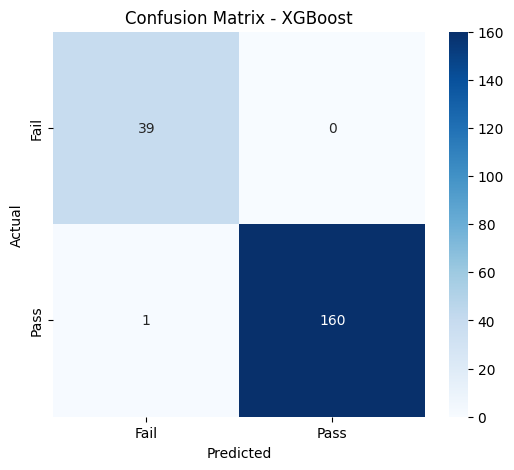

In [24]:
print("Classification Report for XGBoost:\n")
print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()


# Step 9: Hyperparameter Tuning for XGBoost Using GridSearchCV
Tune parameters like number of estimators, max depth, and learning rate to improve model accuracy.


In [25]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
Best cross-validation accuracy: 1.0000


c:\Users\bhanu\Desktop\Student\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:09:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Step 10: Train Tuned XGBoost Model with Best Parameters
Use the best parameters from GridSearchCV and train the final model.


In [26]:
best_params = grid_search.best_params_
xgb_tuned = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **best_params)
xgb_tuned.fit(X_train, y_train)

y_pred_tuned = xgb_tuned.predict(X_test)
print(f"Tuned XGBoost Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")


Tuned XGBoost Accuracy: 0.9950


c:\Users\bhanu\Desktop\Student\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:09:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Step 11: Final Evaluation of Tuned Model
Print detailed classification report and confusion matrix for the tuned XGBoost model.


Classification Report for Tuned XGBoost:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.99      1.00       161

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



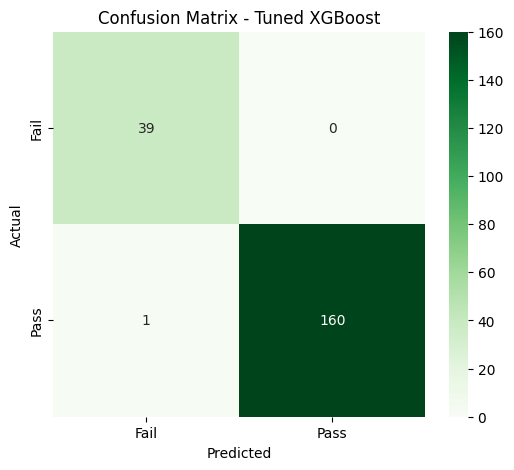

In [27]:
print("Classification Report for Tuned XGBoost:\n")
print(classification_report(y_test, y_pred_tuned))

cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned XGBoost')
plt.show()


In [30]:
scaler.fit(X_train)               # Fit scaler on training features
X_train_scaled = scaler.transform(X_train)  # Scale training data

xgb_tuned.fit(X_train_scaled, y_train)      # Train model on scaled data


c:\Users\bhanu\Desktop\Student\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:37:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [32]:
from sklearn.preprocessing import StandardScaler
import joblib


In [33]:
# 1. Fit scaler on training data
scaler = StandardScaler()
scaler.fit(X_train)


,copy,True
,with_mean,True
,with_std,True


In [34]:
# 2. Transform training data
X_train_scaled = scaler.transform(X_train)

In [35]:
# 3. Train your model
xgb_tuned.fit(X_train_scaled, y_train)

c:\Users\bhanu\Desktop\Student\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [37]:
# 4. Save the scaler and model
joblib.dump(xgb_tuned, "../api/xgb_student_model.pkl")
joblib.dump(scaler, "../api/scaler.pkl")
print("Model and scaler saved successfully.")

Model and scaler saved successfully.
